In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential #new a ajouter dans le rapport 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization # new aajouter dans le rapport
from tensorflow.keras.regularizers import L1L2 #new a ajouter dans le rapport 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # new a ajouter dans le rapport 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time #new a ajouter dans le rapport 
import random
import tensorflow as tf
import os


# 1. Chargement et parsing
df = pd.read_csv('Emission.csv', parse_dates=['Year-Month'], index_col='Year-Month', dayfirst=False)
df.index = pd.to_datetime(df.index, format='%Y-%b')
df.columns = ['CO2']

# 2. Feature Engineering
df['month'] = df.index.month
df['sin_month'] = np.sin(2 * np.pi * df['month']/12)
df['cos_month'] = np.cos(2 * np.pi * df['month']/12)
df.drop('month', axis=1, inplace=True)
df['trend'] = np.arange(len(df))

# 3. Différenciation 
df['CO2_diff'] = df['CO2'].diff().fillna(0)

# 4. Split temporel
train = df.iloc[:int(0.7*len(df))]
val = df.iloc[int(0.7*len(df)):int(0.85*len(df))]
test = df.iloc[int(0.85*len(df)):]

# 5. Normalisation robuste
features = ['CO2_diff', 'sin_month', 'cos_month']
scaler = RobustScaler() #a ajouter dans le rapport 
train_scaled = pd.DataFrame(scaler.fit_transform(train[features]), index=train.index, columns=features)
val_scaled = pd.DataFrame(scaler.transform(val[features]), index=val.index, columns=features)
test_scaled = pd.DataFrame(scaler.transform(test[features]), index=test.index, columns=features)

# Fonction de création des séquences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data.iloc[i:i+n_steps].values)
        y.append(data.iloc[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 24 # Fenêtre étendue trainingsur 24 mois sur 200 iterations
#on utilise pas la window_size 
n_features = len(features)

X_train, y_train = create_sequences(train_scaled, n_steps)
X_val, y_val = create_sequences(val_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# Ajout d'un bruit léger sur X_train pour éviter overfitting
noise = np.random.normal(0, 0.01, X_train.shape)
X_train_noisy = X_train + noise

# 6. Modèle modifié 
model = Sequential([
    LSTM(64, activation='tanh',
         kernel_regularizer=L1L2(l1=1e-4, l2=1e-3),
         return_sequences=True,
         input_shape=(n_steps, n_features)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, activation='tanh',
         kernel_regularizer=L1L2(l2=1e-3)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# 7. Configuration de l'entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

start_time = time.time()
history = model.fit(
    X_train_noisy, y_train,
    epochs=100,
    batch_size=24,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
training_time = time.time() - start_time

# Affichage du résumé
print("\n" + "="*60)
model.summary()
print(f"\nNombre total de paramètres: {model.count_params():,}")
print("="*60 + "\n")

# --- ÉVALUATION ---
def inverse_transform(y_diff, last_values):
    return last_values + y_diff.cumsum()

def evaluate_model(X, y, reference):
    start_time = time.time()
    y_pred = model.predict(X, verbose=0).flatten()
    pred_time = time.time() - start_time
    
    last_train_values = reference['CO2'].iloc[-len(y)-1:-1].values
    y_true = inverse_transform(y, last_train_values)
    y_pred = inverse_transform(y_pred, last_train_values)
    
    return {
        'mse': mean_squared_error(y_true, y_pred),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'rmse':np.sqrt(mse),
        'pred_time': pred_time,
        'true': y_true,
        'pred': y_pred
    }

# Résultats
results = {
    'train': evaluate_model(X_train, y_train, train),
    'val': evaluate_model(X_val, y_val, val),
    'test': evaluate_model(X_test, y_test, test)
}

#prediction de 25 eme mois 
print(f"Temps d'entraînement total: {training_time:.2f} secondes\n")
for dataset in ['train', 'val', 'test']:
    res = results[dataset]
    print(f"=== Ensemble {dataset.upper()} ===")
    print(f"MSE: {res['mse']:.4f}")
    print(f"MAE: {res['mae']:.4f}")
    print(f"R²: {res['r2']:.4f}")
    print(f"Temps de prédiction: {res['pred_time']:.4f} secondes\n")

# --- VISUALISATION ---
plt.figure(figsize=(16, 8))
plt.plot(results['test']['true'], label='Vraies valeurs', color='navy')
plt.plot(results['test']['pred'], label='Prédictions', color='darkorange', linestyle='--')
plt.title('Prédictions sur l\'ensemble de test', fontsize=16)
plt.xlabel('Pas de temps', fontsize=14)
plt.ylabel('CO2 (ppm)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# --- Courbe d'apprentissage ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Courbes de loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


C:\Users\L13\AppData\Local\Temp\ipykernel_18044\988741921.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Emission.csv', parse_dates=['Year-Month'], index_col='Year-Month', dayfirst=False)
C:\Users\L13\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 1.6227 - mae: 0.9881 - val_loss: 0.7527 - val_mae: 0.7009 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1601 - mae: 0.8256 - val_loss: 0.7479 - val_mae: 0.6994 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0796 - mae: 0.7881 - val_loss: 0.7428 - val_mae: 0.6984 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9355 - mae: 0.7343 - val_loss: 0.7428 - val_mae: 0.6967 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7925 - mae: 0.6875 - val_loss: 0.7413 - val_mae: 0.6929 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0322 - mae: 0.7654 - val_loss: 0.7383 - val_mae: 0.6946 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8209 - mae: 0.6785 - val_loss: 0.7387 - val_mae: 0.6925 - learning_rate: 0.0010
Epoc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,341 (352.90 KB)

 Trainable params: 30,049 (117.38 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 60,100 (234.77 KB)


Nombre total de paramètres: 30,241



NameError: name 'mse' is not defined

Valeur prédite pour le prochain mois (25ème mois): 153.26 ppm


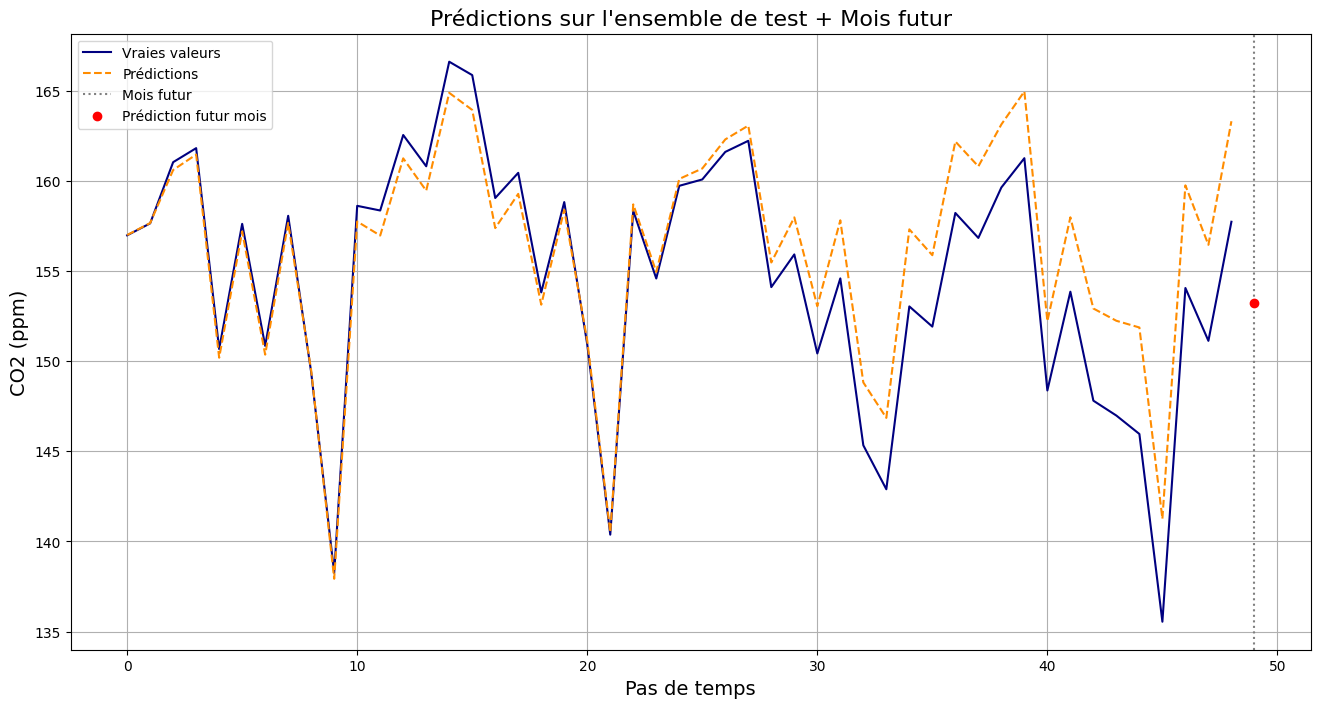

In [7]:
# PRÉDICTION DU MOIS SUIVANT (25ème mois) 
last_sequence = test_scaled.iloc[-n_steps:].values  # dernière séquence connue
last_sequence = last_sequence.reshape(1, n_steps, n_features)
future_diff = model.predict(last_sequence, verbose=0)[0][0]  # prédiction de la diff

# Valeur réelle du dernier mois
last_real_value = df['CO2'].iloc[-1]

# Valeur prédite pour le mois suivant
future_value = last_real_value + future_diff
print(f"Valeur prédite pour le prochain mois (25ème mois): {future_value:.2f} ppm")
# Ajout de la prédiction future au graphe test
true_values = results['test']['true']
pred_values = results['test']['pred']

plt.figure(figsize=(16, 8))
plt.plot(true_values, label='Vraies valeurs', color='navy')
plt.plot(pred_values, label='Prédictions', color='darkorange', linestyle='--')

# Ajout du point futur prédit
plt.axvline(x=len(true_values), color='gray', linestyle=':', label='Mois futur')
plt.scatter(len(true_values), future_value, color='red', label='Prédiction futur mois', zorder=5)

plt.title("Prédictions sur l'ensemble de test + Mois futur", fontsize=16)
plt.xlabel("Pas de temps", fontsize=14)
plt.ylabel("CO2 (ppm)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
